## BC203: Assignment 1 – Principal Component Analysis (PCA)

**Author:** Georgios Kousis Tsampazis

---

### Background

Principal Components Analysis (PCA) is an unsupervised machine learning method for dimensionality
reduction. In many cases, however, it can also help understand the information contained in the data. The
PCA process typically involves obtaining the eigenvectors and accompanying eigenvalues using the data's
covariance (or correlation matrix).

### Overview

Your assignment is to execute PCA on a synthetic dataset derived from the well-known machine learning
module in Python called scikit-learn (i.e., [sklearn]("https://scikit-learn.org/stable/")).

---

### Part 1: Custom PCA Implementation

1. **Data Generation**

   * Use the function `sklearn.datasets.make_blobs`.
2. **Costum PCA**
   * Center the data and compute its covariance matrix.
   * Extract eigenvalues, eigenvectors and compute the loadings.
   * Project the data onto the top principal components.

---

### Part 2: Data Analysis and Visualization

1. **2D PCA Plot**
   * Scatter the data onto the first two principal components and color‐code any "clusters".
2. **Loadings & Feature Contributions**

   * Examine the loadings to interpret which original features contribute most to each principal component.
3. **3D PCA Plot**

   * Visualize the first three principal components in a 3D scatter plot.

---

### Part 3: Noise Comparison

1. **Generate Noisy Data**
2. **Re-run PCA**

   * Compare explained variance ratios between the clean and noisy data.
   * Discuss how noise affects PCA’s ability to capture true structure.

---

## Notebook Structure

1. **Setup & Dependencies**

2. **Data Preparation**

3. **PCA Implementation**

4. **Visualization & Interpretation**
5. **Discussion**

---

> *>Barges into any discussion or argument* \
*>PCA is just eigenvectors of the covariance matrix* \
*>Refuses to elaborate further* \
*>Leaves*

---


### Noteboook dependencies
*As always a conda enviroment is recommended for easier installation*

In [180]:
pip install scikit-learn numpy matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


### Retrieve a synthetic dataset

We use scikit-learn’s `make_blobs` to generate a toy clustering dataset with 1,000 samples in 20-dimensional space. The points are drawn from three Gaussian clusters (std = 1.0), and for reproducibility we set `random_state` to the last two digits of my student ID.


In [67]:
from sklearn.datasets import make_blobs
X, y_labels = make_blobs(n_samples=1000,n_features=20,centers=3,cluster_std=1.0,random_state=91)

### PCA Algorithmic Steps

1. **Data Centering**  
   1. Compute the feature-wise mean:  
      $\displaystyle \mu = \frac{1}{n}\sum_{i=1}^n X_i$  
   2. Center the data:  
      $\displaystyle X_c = X - \mu$

2. **Choose Decomposition Method**  
   - **Eigen-decomposition (`method='eig'`)**  
     1. Compute the covariance matrix:  
        $\displaystyle C = \frac{1}{n-1}\,X_c^\top X_c$  
     2. Solve the eigenproblem:  
        $\displaystyle C\,v_j = \lambda_j\,v_j$  
     3. Sort eigenvalues $\lambda_j$ in descending order and reorder eigenvectors $v_j$ accordingly.  
   - **Singular Value Decomposition (`method='svd'`)**  
     1. Compute the thin SVD:  
        $\displaystyle X_c = U\,S\,V^\top$  
     2. Relate singular values to eigenvalues:  
        $\displaystyle \lambda_j = \frac{S_j^2}{\,n-1\,}$  
     3. The principal axes are the columns of $V$.

3. **Compute Explained-Variance Ratios**  
   $\displaystyle \text{var\_ratio}_j = \frac{\lambda_j}{\sum_{i=1}^p \lambda_i}$

4. **Select Number of Components**  
   - **Fixed count**: keep the first `keep_dims` components.  
   - **Variance threshold**: choose the smallest \(k\) to reach the wanted variant

5. **Project Data**  
   Form the loading matrix $W = [\,v_1,\dots,v_k\,]$ and compute the PCA scores:  
   $\displaystyle Z = X_c\,W,\quad Z\in\mathbb{R}^{n\times k}\,$.


### Custom PCA implementation

The `custom_pca` function performs Principal Component Analysis on an input dataset `X`, either by retaining a fixed number of components (`keep_dims`) or enough components to reach a desired explained‐variance threshold (`var_threshold`). It supports two computation methods—eigen‐decomposition of the covariance matrix (`method='eig'`) or Singular Value Decomposition (`method='svd'`)—and returns the projected data `Z`, the principal‐component loadings, and the array of explained‐variance ratios.


In [153]:
import numpy as np

def custom_pca(X, keep_dims=None, var_threshold=None, method='eig'):
    """
    PCA that either keeps a fixed number of components (keep_dims)
    or enough to reach var_threshold.  Use exactly one of them or bad thing will happen to you
    Input:
        X = Your data
        *keep_dims = How many dimensios you want to keep 
        *var_threshold = How much variance you want to capture
        method = Which method you want to use; eigen decomposition (eig) or SVD (svd) are supported
    """
    if (keep_dims is None) == (var_threshold is None):
        raise ValueError("Specify exactly one of keep_dims or var_threshold")
    # 1. center
    mu = np.mean(X, axis=0)
    Xc = X - mu
    n, p = Xc.shape

    # 2. decomposition
    if method == 'eig':
        C = np.cov(Xc, rowvar=False)
        eigvals, eigvecs = np.linalg.eig(C)
        idx = np.argsort(eigvals)[::-1]
        eigvals, eigvecs = eigvals[idx], eigvecs[:, idx]
        loadings_all = eigvecs
    elif method == 'svd':
        U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
        eigvals = (S**2) / (n - 1)
        loadings_all = Vt.T
    else:
        raise ValueError("method must be 'eig' or 'svd'")

    # 3. explained variance ratios
    var_ratios = eigvals / np.sum(eigvals)

    # 4. select dims
    if var_threshold is not None:
        cumvar = np.cumsum(var_ratios)
        keep_dims = np.searchsorted(cumvar, var_threshold) + 1
        print(
    f"► Selected {keep_dims} PCs for ≥{var_threshold*100:.1f}% variance; "
    f"cumulative explained variance is {cumvar[keep_dims-1]*100:.2f}%"
    )
    else:
        explained = np.sum(var_ratios[:keep_dims])
        print(f"► Keeping {keep_dims} PCs = {explained*100:.1f}% var")

    # 5. fix sign
    for j in range(loadings_all.shape[1]):
        pc = loadings_all[:, j]
        if pc[np.argmax(np.abs(pc))] < 0:
            loadings_all[:, j] = -pc

    # 6. project
    loadings = loadings_all[:, :keep_dims]
    Z = Xc @ loadings
    return Z, loadings, var_ratios

In [154]:
# Q1) PCA to retain ≥80% variance
Z80, L80, vr80 = custom_pca(X, var_threshold=0.8, method='eig')

► Selected 2 PCs for ≥80.0% variance; cumulative explained variance is 95.49%


#### Check Eigen decomposition and SVD (varify PCA) 

In [156]:
# Run PCA via both methods, keeping all 4 PCs
_, load_eig, _ = custom_pca(X, keep_dims=4, method='eig')
_, load_svd, _ = custom_pca(X, keep_dims=4, method='svd')

# Compare squared loadings to eliminate sign ambiguity
sq_eig = load_eig ** 2
sq_svd = load_svd ** 2

# Check equality
equal = np.allclose(sq_eig, sq_svd, atol=1e-8)
max_diff = np.max(np.abs(sq_eig - sq_svd))

print("Are squared loadings equal?  ", equal)
print("Maximum absolute difference:", max_diff)

► Keeping 4 PCs = 96.1% var
► Keeping 4 PCs = 96.1% var
Are squared loadings equal?   True
Maximum absolute difference: 5.040759476493406e-14


`Question 1. How many dimensions must we keep to maintain 80% of the total variance? Show the relevant plot
(e.g., variance explained as a function of dimensions). Project the data by keeping these dimensions.`

#### To maintain at least **80%** of the variance, we need at to retain 2 dimensions, which in total explain about **95.81%** of datas' variance


## Relevant Plots

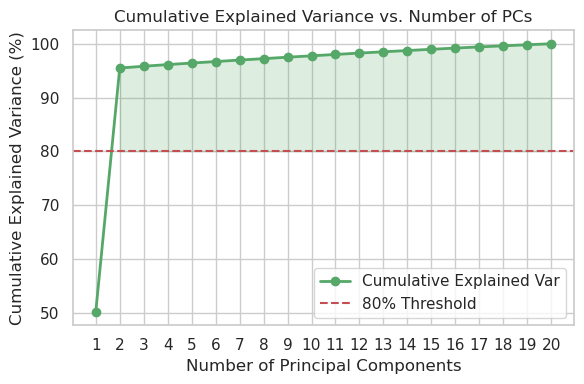

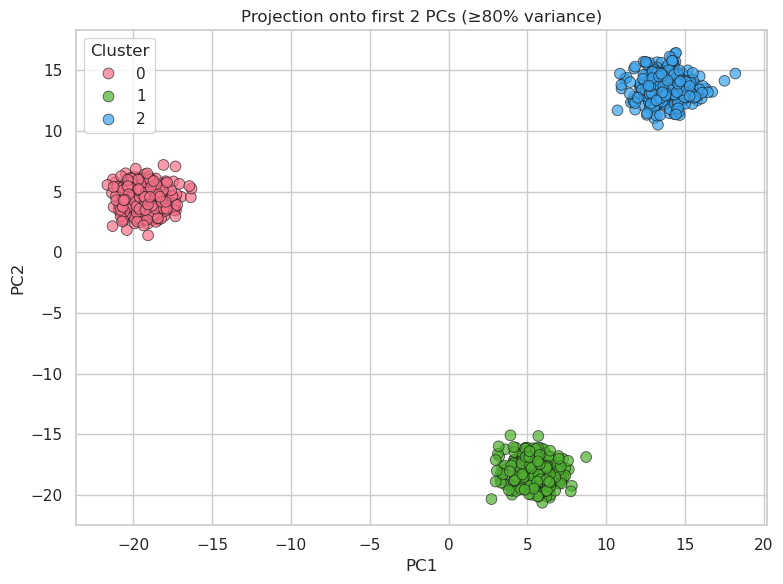

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# 1) Prepare cumulative explained variance
cumvar = np.cumsum(vr80) * 100
dims = np.arange(1, len(vr80) + 1)  
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
plt.plot(dims, cumvar, marker='o', linewidth=2, color='C2', label='Cumulative Explained Var')
plt.axhline(80, linestyle='--', color='C3', linewidth=1.5, label='80% Threshold')
plt.fill_between(dims, cumvar, 80, where=cumvar >= 80, color='C2', alpha=0.2)
plt.xticks(dims)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Cumulative Explained Variance vs. Number of PCs')
plt.legend()
plt.tight_layout()
plt.show()

# 2) 2D projection scatter with a pretty palette
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=Z80[:, 0], y=Z80[:, 1],
    hue=y_labels.astype(str), # True labels 
    palette="husl", 
    edgecolor='k', s=60, alpha=0.7```
)
plt.title(f'Projection onto first {Z80.shape[1]} PCs (≥80% variance)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


`Question 2. Plot the loadings of the first two principal components in the same plot. Do you think that some
features are not needed? If yes, explain why. If no, explain why.`

#### Code to Plot loadings values of the first two componets and mark importance


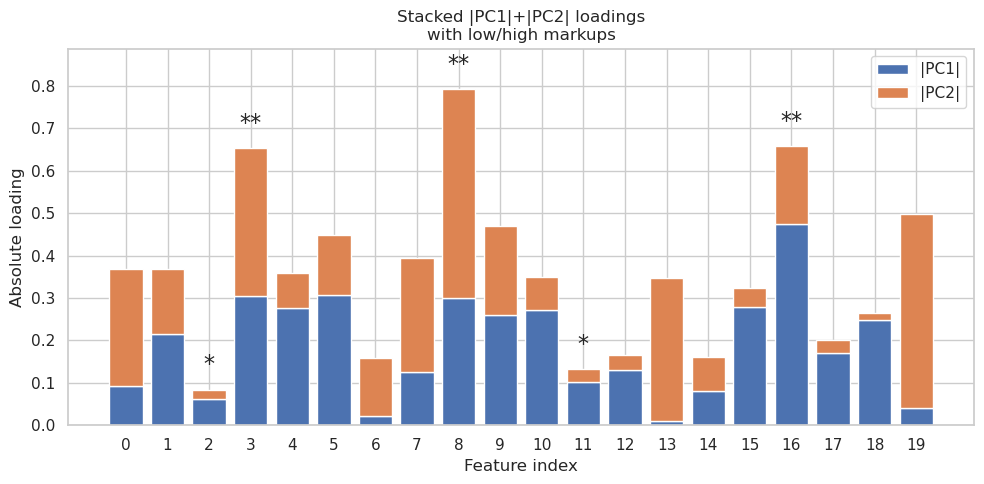

In [170]:
import numpy as np
import matplotlib.pyplot as plt

loadings = L80
n_feats = loadings.shape[0]
inds    = np.arange(n_feats)

# compute absolute values
abs_pc1 = np.abs(loadings[:, 0])
abs_pc2 = np.abs(loadings[:, 1])

# compute aggregate and its 10th/85th percentile thresholds
agg = abs_pc1 + abs_pc2
low_thr, high_thr = np.percentile(agg, [10, 85])

# make the stacked bar-plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(inds, abs_pc1, label='|PC1|')
ax.bar(inds, abs_pc2, bottom=abs_pc1, label='|PC2|')

# compute a small offset for placing stars above the bars
y_offset = agg.max() * 0.04

# annotate tail features, always at the top of the bars
for i in inds:
    y_top = agg[i]
    if agg[i] < low_thr:
        ax.text(i, y_top + y_offset, '*',
                ha='center', va='bottom', fontsize=16)
    elif agg[i] > high_thr:
        ax.text(i, y_top + y_offset, '**',
                ha='center', va='bottom', fontsize=16)

# cosmetics
ax.set_xticks(inds)
ax.set_xlabel('Feature index')
ax.set_ylabel('Absolute loading')
ax.set_title('Stacked |PC1|+|PC2| loadings\nwith low/high markups')
ax.legend()
ax.set_ylim(0, agg.max() + 3*y_offset)

plt.tight_layout()
plt.show()

#### In order to not choose based on subjective values (at least by seeing the plot), I added a more common heuristic technique and I deem important the upper 85th percentile while most unimportant the lower 10th percentile, so Features 8, 3 and 16 emerge as the strongest drivers (each with a sum loading > 0.6) and Features 2 and 11 are flagged as negligible.


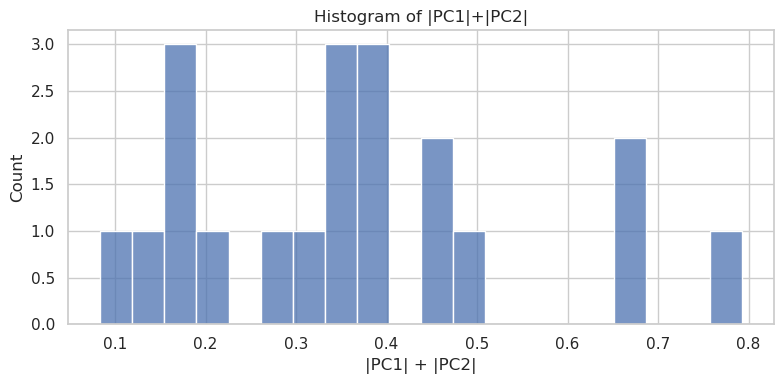

In [167]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

loadings = L80

# 1) compute the per-feature sums of abs-loadings
abs_pc1 = np.abs(loadings[:, 0])
abs_pc2 = np.abs(loadings[:, 1])
sums    = abs_pc1 + abs_pc2

# 2) pick the two feature indices to mark
idxs_to_mark = [8, 16]
vals_to_mark = sums[idxs_to_mark]

# 3) plot the histogram of the sums
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(sums, bins=20, ax=ax)


ax.set_xlabel('|PC1| + |PC2|')
ax.set_ylabel('Count')
ax.set_title('Histogram of |PC1|+|PC2|')
plt.tight_layout()
plt.show()



#### From the histogram, we see that most absolute loading sum values cluster in the low‐to‐medium range, with only three features exceeding the 0.6 mark. These three—Features 8, 3 and 16—stand out as the dominant contributors to the PC₁–PC₂ subspace, so focusing on them alone would likely preserve the essential structure of the data in our 2D projection.


Keeping 3 of 20 features (top 5%)
► Keeping 2 PCs = 99.3% var


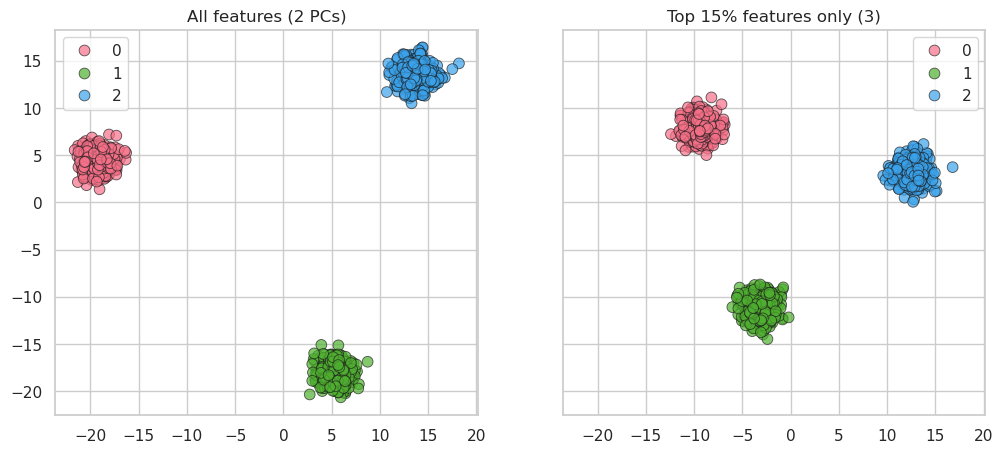

<Figure size 800x600 with 0 Axes>

In [169]:
keep_idx= [8,16,3]
print(f"Keeping {len(keep_idx)} of {loadings.shape[0]} features (top 5%)")

# 1) Build reduced X and re-run PCA on 2 PCs
X_reduced = X[:, keep_idx]
Z_red, L_red, vr_red = custom_pca(X_reduced, keep_dims=2, method='eig')

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

# Original 2-PC scatter
sns.scatterplot(x=Z80[:,0], y=Z80[:,1], 
                hue=y_labels.astype(str), 
                palette="husl",
                edgecolor="k",
                ax=axes[0], s=60, alpha=0.7)
axes[0].set_title("All features (2 PCs)")

# Reduced 2-PC scatter
sns.scatterplot(x=Z_red[:,0], y=Z_red[:,1], hue=y_labels.astype(str),
                 palette="husl",
                edgecolor="k", ax=axes[1],s=60,alpha=0.7)
axes[1].set_title(f"Top 15% features only ({len(keep_idx)})")

plt.tight_layout()
plt.show()


#### As we can see, the overall cluster structure is still preserved—although the blobs draw closer, we can clearly distinguish the three distributions and retain the bulk of their variance. In practice, this means you can safely exclude features whose loadings are near zero on both PCs without losing the essential 2-D separation: only the three strongest features (those in the top 85th percentile) are strictly necessary to reproduce the Gaussian‐blob arrangement. However, whether to drop low-loading features depends on your downstream goals. If your only aim is to capture and visualize the three blobs in low dimensions, retaining just those two features (or PCs) is sufficient. But in contexts like gene‐expression analysis—where even small contributions might drive important biological pathways—filtering out “weak” variables could obscure meaningful signals, so it’s wiser to keep a larger set of features.


#### Choosing worst features

Keeping 2 of 20 features (top 5%)
► Keeping 2 PCs = 100.0% var


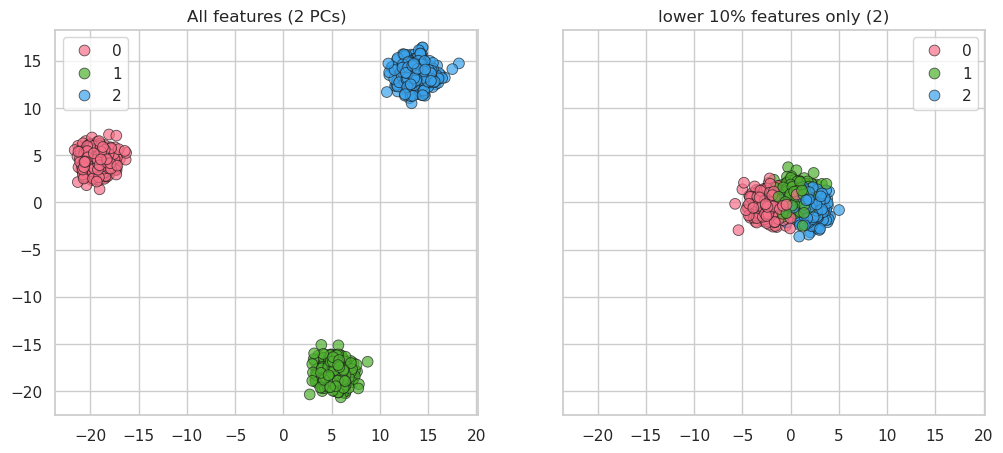

<Figure size 800x600 with 0 Axes>

In [161]:
import numpy as np
loadings = L80

keep_idx= [2,11]
print(f"Keeping {len(keep_idx)} of {loadings.shape[0]} features (top 5%)")

# 1) Build reduced X and re-run PCA on 2 PCs
X_reduced = X[:, keep_idx]
Z_red, L_red, vr_red = custom_pca(X_reduced, keep_dims=2, method='eig')

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
plt.figure(figsize=(8, 6))
# Original 2-PC scatter
sns.scatterplot(x=Z80[:,0], y=Z80[:,1], 
                hue=y_labels.astype(str), 
                palette="husl",
                edgecolor="k",
                ax=axes[0], s=60, alpha=0.7)
axes[0].set_title("All features (2 PCs)")

# Reduced 2-PC scatter
sns.scatterplot(x=Z_red[:,0], y=Z_red[:,1], hue=y_labels.astype(str),
                 palette="husl",
                edgecolor="k", ax=axes[1],s=60,alpha=0.7)
axes[1].set_title(f"lower 10% features only ({len(keep_idx)})")

plt.tight_layout()
plt.show()


`Question 3. Show the plot of the projected data using the first two or three principal components.`

### Plotting

► Keeping 3 PCs = 95.8% var
► Keeping 2 PCs = 95.5% var


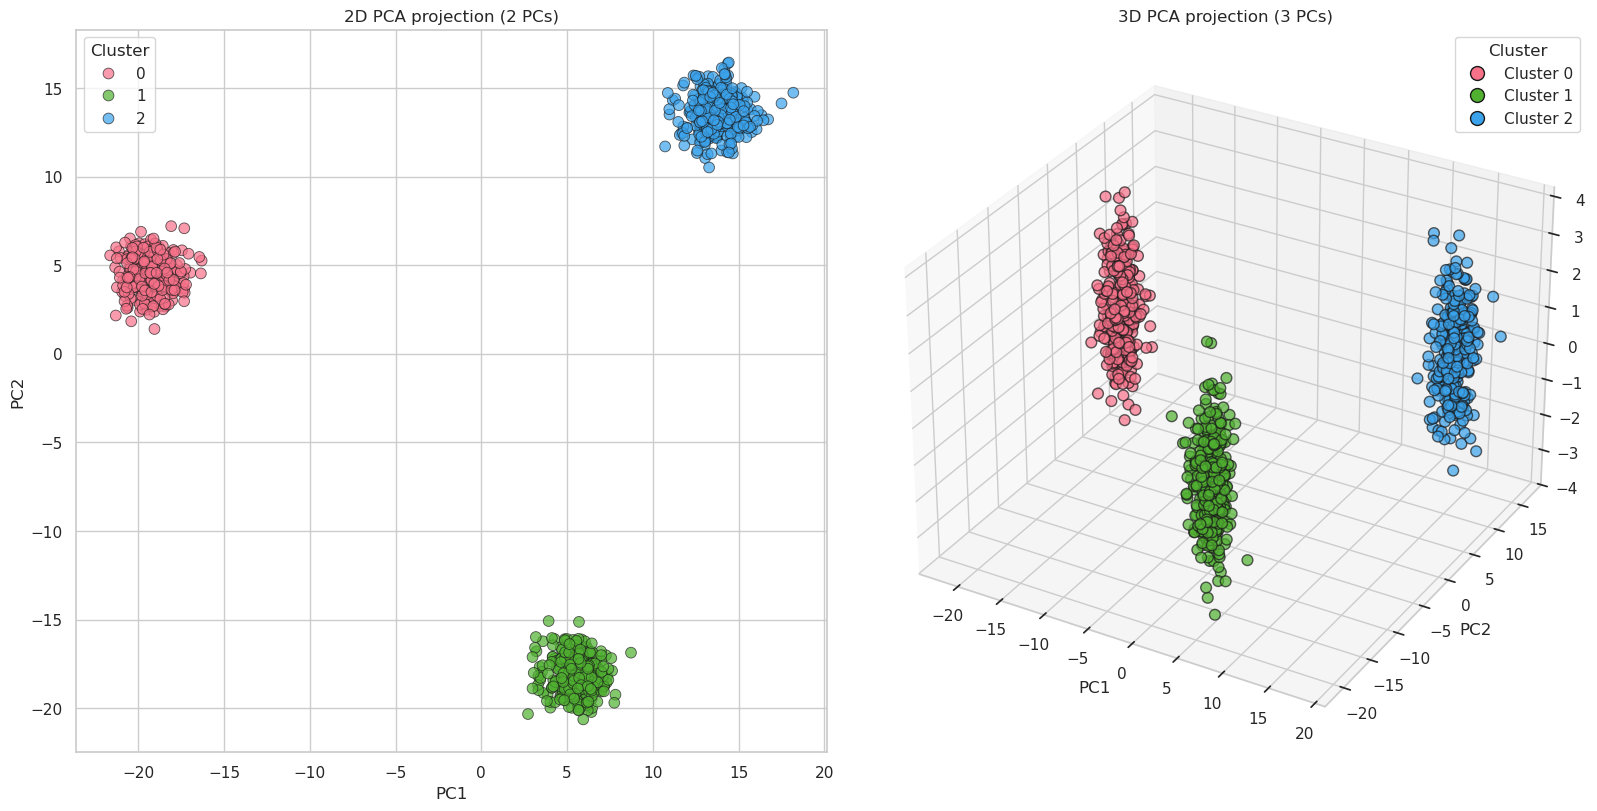

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Z3, L3, vr3 = custom_pca(X, keep_dims=3, method='eig')
Z2, L2, vr2 = custom_pca(X, keep_dims=2, method='eig')

sns.set(style="whitegrid")

# Create a larger figure with more room for the 3D plot
fig = plt.figure(figsize=(16, 8), constrained_layout=True)

# 2D PCA projection
ax1 = fig.add_subplot(1, 2, 1)
sns.scatterplot(
    x=Z2[:, 0], y=Z2[:, 1],
    hue=y_labels.astype(str), # color by true labels
    palette="husl",
    edgecolor='k', s=60, alpha=0.7,
    ax=ax1
)
ax1.set_title('2D PCA projection (2 PCs)')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.legend(title="Cluster")

# 3D PCA projection
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
unique_labels = np.unique(y_labels)
palette3d = sns.color_palette("husl", n_colors=len(unique_labels))
# Map each sample’s label to an RGB tuple
colors3d = [palette3d[int(lbl)] for lbl in y_labels]

# scatter
pts = ax2.scatter(
    Z3[:, 0], Z3[:, 1], Z3[:, 2],
    color=colors3d, s=60, alpha=0.7, edgecolors='k'
)
ax2.set_title('3D PCA projection (3 PCs)')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')

# Create legend for the 3D plot
from matplotlib.lines import Line2D
legend_elems = [
    Line2D([0], [0], marker='o', color='w', label=f'Cluster {lbl}',
           markerfacecolor=palette3d[i], markersize=10, markeredgecolor='k')
    for i, lbl in enumerate(unique_labels)
]
ax2.legend(handles=legend_elems, title="Cluster", loc='upper right')

plt.show()


### Generate Noiser Data

In [ ]:
X1, y1_labels = make_blobs(
    n_samples=1000, centers=3, n_features=20,
    cluster_std=4.0, random_state=91
)

Z3n, L3n, vr3n = custom_pca(X1, keep_dims=3, method='eig')
Z2n, L2n, vr2n = custom_pca(X1, keep_dims=2, method='eig')


► Keeping 3 PCs = 61.7% var
► Keeping 2 PCs = 58.7% var


#### Analysing The Noiser Dataset

` Question 4 Re-run the PCA with the reduction found in step 1, but with new data with cluster_std=4.0 in the
make_blobs function. Compare the new projection and discuss what you observe in a short
paragraph. `

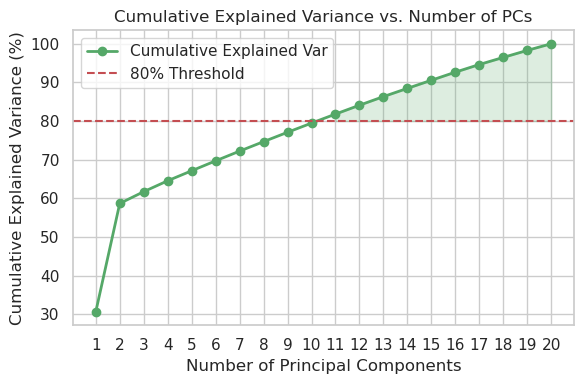

<Figure size 1600x800 with 0 Axes>

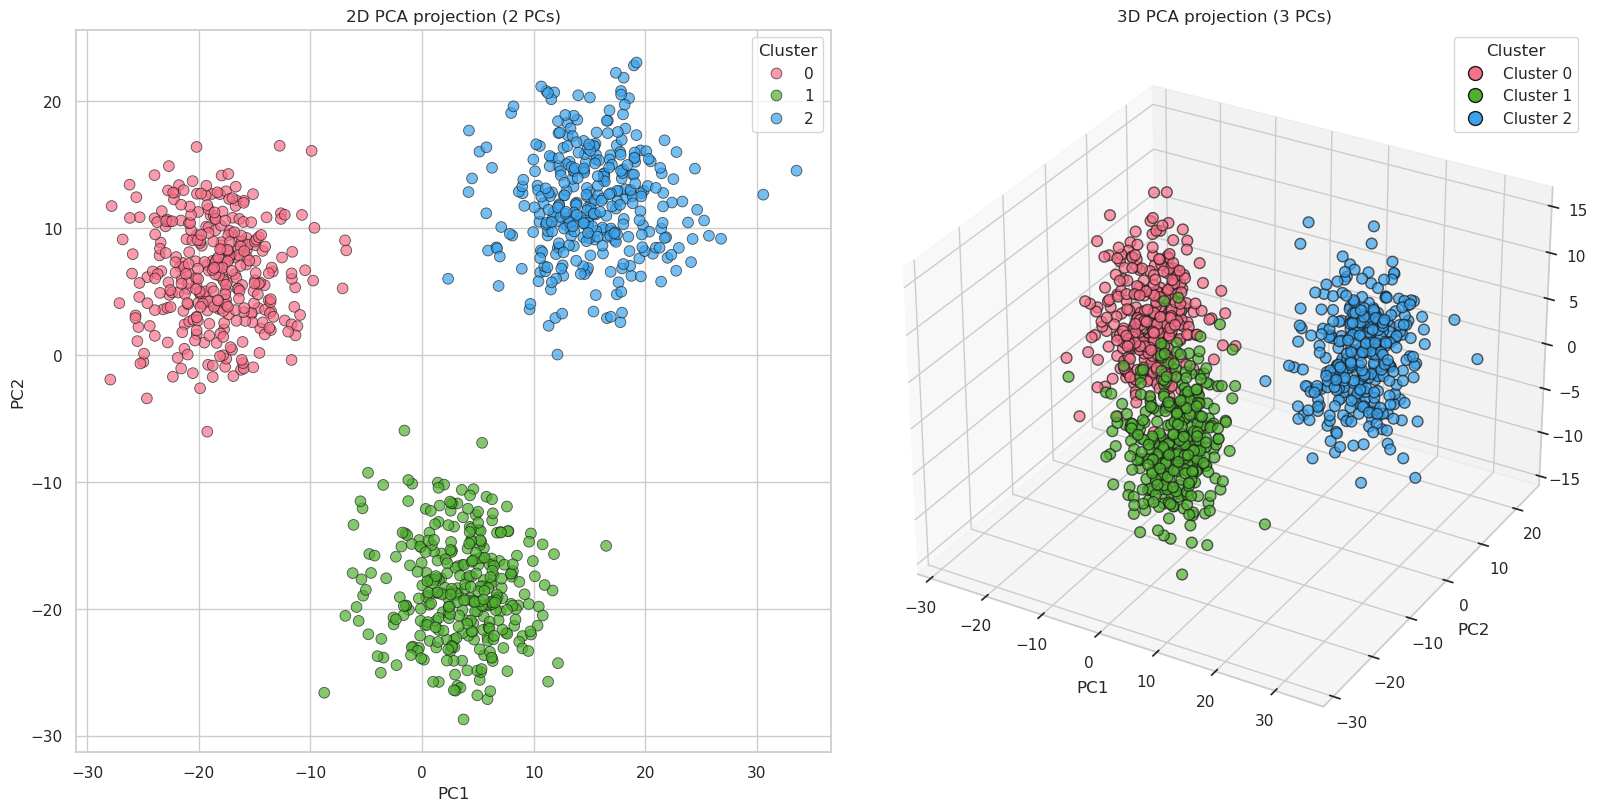

In [ ]:
sns.set(style="whitegrid")
# 1) Prepare cumulative explained variance
cumvar = np.cumsum(vr2n) * 100
dims = np.arange(1, len(vr2n) + 1)  
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
plt.plot(dims, cumvar, marker='o', linewidth=2, color='C2', label='Cumulative Explained Var')
plt.axhline(80, linestyle='--', color='C3', linewidth=1.5, label='80% Threshold')
plt.fill_between(dims, cumvar, 80, where=cumvar >= 80, color='C2', alpha=0.2)
plt.xticks(dims)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Cumulative Explained Variance vs. Number of PCs')
plt.legend()
plt.tight_layout()
plt.show()
fig = plt.figure(figsize=(16, 8), constrained_layout=True)
sns.set(style="whitegrid")
# 2D PCA projection
ax1 = fig.add_subplot(1, 2, 1)
sns.scatterplot(
    x=Z2n[:, 0], y=Z2n[:, 1],
    hue=y1_labels.astype(str), # color by true labels
    palette="husl",
    edgecolor='k', s=60, alpha=0.7,
    ax=ax1
)
ax1.set_title('2D PCA projection (2 PCs)')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.legend(title="Cluster")

# 3D PCA projection
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
unique_labels = np.unique(y1_labels)
palette3d = sns.color_palette("husl", n_colors=len(unique_labels))
# Map each sample’s label to an RGB tuple
colors3d = [palette3d[int(lbl)] for lbl in y1_labels]

# scatter
pts = ax2.scatter(
    Z3n[:, 0], Z3n[:, 1], Z3n[:, 2],
    color=colors3d, s=60, alpha=0.7, edgecolors='k'
)
ax2.set_title('3D PCA projection (3 PCs)')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')

# Create a proxy legend for the 3D plot
from matplotlib.lines import Line2D
legend_elems = [
    Line2D([0], [0], marker='o', color='w', label=f'Cluster {lbl}',
           markerfacecolor=palette3d[i], markersize=10, markeredgecolor='k')
    for i, lbl in enumerate(unique_labels)
]
ax2.legend(handles=legend_elems, title="Cluster", loc='upper right')

plt.show()





#### When we Increase  `cluster_std` from 1.0 to 4.0 but still only keep the two PCs that once explained ≥ 80 % of the variance, the three Gaussian clouds in the PC₁–PC₂ plot remain distinct—but their edges press tightly against one another, almost touching. At the same time, the scree‐plot shifts dramatically: whereas only 2 components were needed to hit 80 % variance before, you now need 10 PCs to reach the same threshold. As a result, any analysis (clustering, classification, etc.) confined to just the first two PCs will see its separation power degrade, because the added within‐cluster “noise” inflates overall variance and dilutes the true between‐cluster signal.


**If you want a more comprehensive explaiantion of the results ask me for the Result's Report**